# 更好地理解正则化：可视化模型权重分布

在机器学习中，经常需要对模型进行正则化，以降低模型对数据的过拟合程度，那么究竟如何理解正则化的影响？本文尝试从可视化的角度来解释其影响。

首先，正则化通常分为三种,都是在loss函数的基础上外加一项：

L0： $\lambda\times||x||_{0}$ ，即不等于0的元素个数

L1： $\lambda\times||x||_{1}$ ，即所有元素的绝对值之和

L2： $\lambda\times||x||_{2}$ ，即所有元素的绝对值平方和

训练模型的时候，模型将在保证loss主体损失下降的情况下，尽量保证权重往这些方向走，从L1,L2的函数中就可以看出，在做梯度下降的时候，这些函数都将把权重赶向接近0的地方，让权重变得更加稀疏，大部分数据都在0附近。

从最小化结构风险的角度来看（这个和奥卡姆剃刀律有异曲同工之妙），在多个模型中，我们选择最简单的那个模型作为最好的模型，而不是最复杂的，权重分布最离散的那个。

从人类的角度来看，神经元（千亿量级）的连接是极为稀疏的，平均每个神经元不超过十万，这与总的神经元个数之间有极大的差距（至少六个数量级的差距），因此从先验的角度来看，我们最好训练一个连接极少（权重0极多）的模型才接近人类大脑。

可惜，L0正则化是一个NP难问题，我们很难保证准确率的前提下，挑选哪些元素是0，哪些不是，因此，一般我们用L1替代L0（具体为什么我也不清楚…但是效果是挺好）

为了更好地理解将权重赶向0的过程，我在mnist上训练一个经典的CNN分类器，提取出所有的权重，求出其分布来看看。（所有权重初始化为均值0，方差0.5的正态分布）

## 下面是图片（正则化强度均为1e-4）：

无正则化

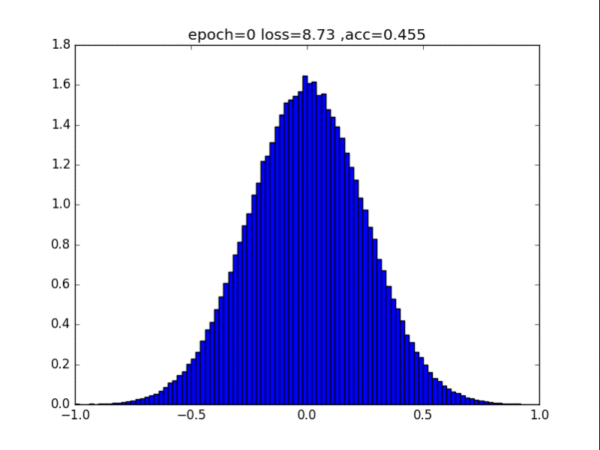

L1正则化

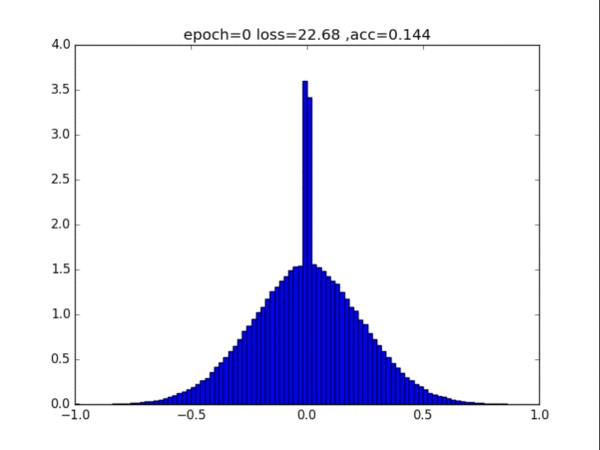

L2正则化

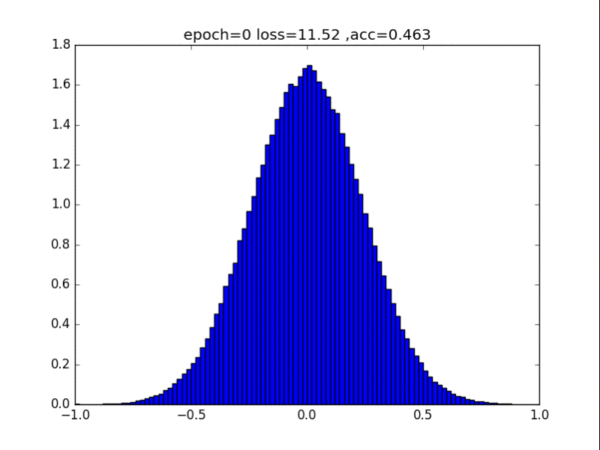

## 从中我们能得到什么信息呢？

1. L1L2正则化如实地将权重往0的方向赶，但是L1赶得快，L2比较慢一些，在30epoch以上L2才有类似于L1的一枝独秀的分布。

2. 在测试集上，没有正则化，L1,L2正则化的准确率基本都一样（有正则化的略高），这样一来，在保证准确率的前提下，L1L2正则化能够省下更多的元素，这就意味着模型能够大大地减少其存储空间（将矩阵变成稀疏矩阵的形式保存）

为了解释这个问题，我们可以回到L1,L2的函数图像来看。元素绝对值在$[0,1]$之间的时候，L1对于元素的惩罚更大，L2的惩罚小，相对的容忍度更大。元素绝对值在$[1，∞]$之间的时候，L1对于元素的惩罚更小，L2的惩罚大，相对的容忍度更小。

从斜率角度来看，L2正则化的斜率大要在$[1，∞]$才能发挥其功力，在$[0,1]$之间，往0赶的能力不是很强。然而L1在所有地方斜率都一样，相对而言，在$[0,1]$之间，其往0赶的能力强。

L1与L2正则化的对比

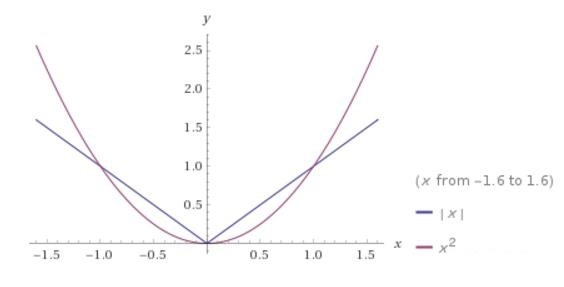

## 彩蛋

事实上Keras允许自定义正则化函数，我们也可以多定义几种正则化方式玩玩：

诡异的“L3正则化”，可能是三次方往0赶的能力实在太差，多数元素都在0附近徘徊所致

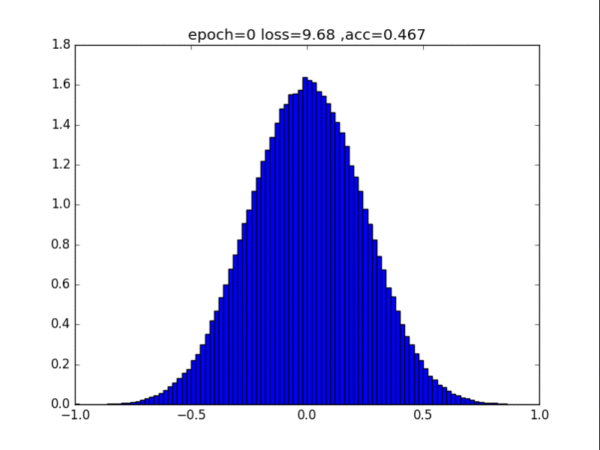

L3正则化，函数$y=|x|^3$

为了证明对“L3正则化”的解释，试了试“L4正则化”，看起来确实如此，四次方往0赶的能力更差

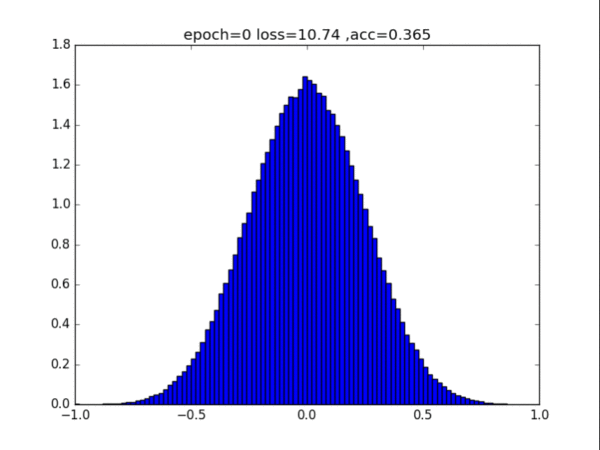

L4正则化，函数$y=|x|^4$

有死区的L1，在-a到a之间没有惩罚，效果类似于L1，也能让0更多（还有为啥loss小于0了…）

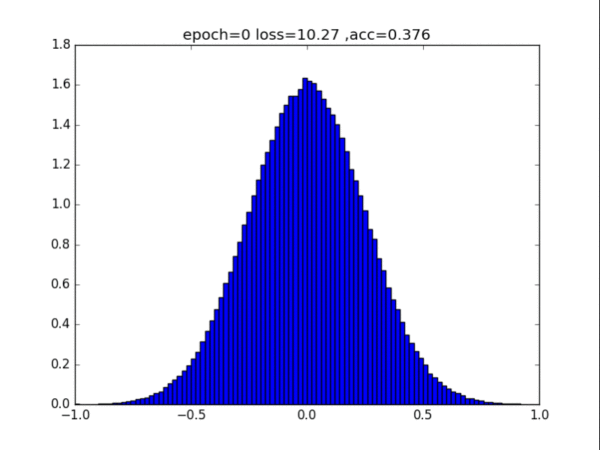

有死区的L1，函数y=max(0,|x|-a)，其中a=0.25

代码：

In [ ]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten,Input
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import initializers
import numpy as np
import matplotlib.pyplot as plt
from keras import regularizers
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28,1)
x_test = x_test.reshape(x_test.shape[0], 28, 28,1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_test /= 255.0
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)
def my_reg(weight_matrix):
    return 1e-4 * K.sum(K.max(K.abs(weight_matrix) - 0.25,0))
    #return 1e-4 * K.sum(K.pow(K.abs(weight_matrix),2))

init = initializers.random_normal(mean=0,stddev=0.25,seed=42)
input = Input(shape=(28,28,1))
conv1 = Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer=init,kernel_regularizer=my_reg)(input)
conv2 = Conv2D(64, (3, 3), activation='relu',kernel_initializer=init,kernel_regularizer=my_reg)(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu',kernel_initializer=init,kernel_regularizer=my_reg)(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)
flat = Flatten()(pool2)
dense1 = Dense(128, activation='relu',kernel_initializer=init,kernel_regularizer=my_reg)(flat)
output = Dense(10, activation='softmax',kernel_initializer=init,kernel_regularizer=my_reg)(dense1)
model = Model(inputs=input,outputs=output)
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])
model.summary()

for i in range(40):
    model.fit(x_train, y_train, batch_size=128, epochs=1, verbose=0, validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=0)
    weights = model.get_weights()
    all_weights = np.zeros([0, ])
    for w in weights:
        w_flatten = np.reshape(w, [-1])
        all_weights = np.concatenate([all_weights, w_flatten], axis=0)
    plt.hist(all_weights, bins=100,color="b",normed=True,range=[-1,1])
    plt.title("epoch="+str(i)+" loss=%.2f ,acc=%.3f"%(score[0],score[1]))
    plt.savefig("mnist_model_weights_hist_%d.png"%(i))
    plt.clf()

In [ ]:
参考文献：

[1]Stephen Boyd，凸优化Convex Optimization,清华大学出版社，286-290

[2]Ian Goodfellow，深度学习Deep Learning，人民邮电出版社,141-145